In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from construct import *

import collections

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.max_open_warning'] = 0

In [2]:
frames = np.fromfile('apm1_frames_2024-01-08_22-10-22.u8', 'uint8').reshape(-1, 4 * 223 - 2)
frames.shape

(5116, 890)

In [3]:
# hack the check to allow packets with ccsds_version different from 0
ccsds.check_space_packet_header = lambda packet: True

In [4]:
CLCW = BitStruct(
    'control_word_type' / Flag,
    'clcw_version_number' / BitsInteger(2),
    'status_field' / BitsInteger(3),
    'cop_in_effect' / BitsInteger(2),
    'virtual_channel_identification' / BitsInteger(6),
    'rsvd_spare' / BitsInteger(2),
    'no_rf_avail' / Flag,
    'no_bit_lock' / Flag,
    'lock_out' / Flag,
    'wait' / Flag,
    'retransmit' / Flag,
    'farm_b_counter' / BitsInteger(2),
    'rsvd_spare2' / BitsInteger(1),
    'report_value' / BitsInteger(8)
)

TMFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / Bytes(4 * 223 - 2 - 6 - 2 - 4),
    'ocf' / CLCW,
)

# AOS frames

The frames are AOS frames using spacecraft ID `0xe0` (there doesn't appear to be a corresponding assignment in SANA). Virtual channels 0 and 63 (the only-idle-data virtual channel) are in use. There is an OCF carrying a CLCW.

In [5]:
tm = [TMFrame.parse(f) for f in frames]
scid = [a.primary_header.spacecraft_id for a in tm]
vcid = np.array([a.primary_header.virtual_channel_id for a in tm])
vcfc = np.array([a.primary_header.virtual_channel_frame_count for a in tm])
[a.primary_header for a in tm[:5]]

[Container(transfer_frame_version_number=1, spacecraft_id=224, virtual_channel_id=0, virtual_channel_frame_count=78938, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=224, virtual_channel_id=0, virtual_channel_frame_count=78939, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=224, virtual_channel_id=0, virtual_channel_frame_count=78940, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=224, virtual_channel_id=0, virtual_channel_frame_count=78941, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=224, virtual_channel_id=0, virtual_channel_frame_count=78942, replay_flag=False, vc_frame_count_usage_

In [6]:
[a.m_pdu_header for a in tm[:10]]

[Container(rsv_spare=0, first_header_pointer=11),
 Container(rsv_spare=0, first_header_pointer=0),
 Container(rsv_spare=0, first_header_pointer=282),
 Container(rsv_spare=0, first_header_pointer=0),
 Container(rsv_spare=0, first_header_pointer=0),
 Container(rsv_spare=0, first_header_pointer=0),
 Container(rsv_spare=0, first_header_pointer=0),
 Container(rsv_spare=0, first_header_pointer=0),
 Container(rsv_spare=0, first_header_pointer=0),
 Container(rsv_spare=0, first_header_pointer=133)]

In [7]:
collections.Counter(scid)

Counter({224: 5116})

In [8]:
collections.Counter(vcid)

Counter({0: 5070, 63: 46})

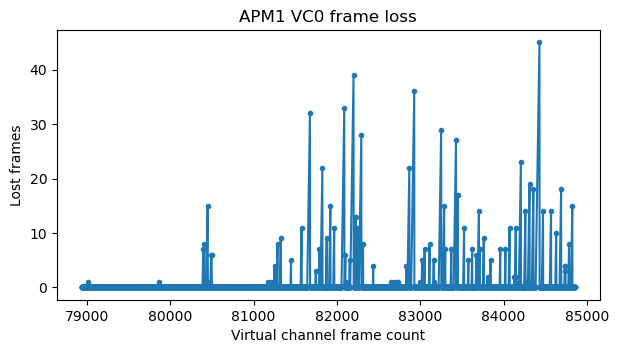

In [9]:
plt.plot(vcfc[vcid == 0][1:], np.diff(vcfc[vcid == 0]) - 1, '.-')
plt.title('APM1 VC0 frame loss')
plt.xlabel('Virtual channel frame count')
plt.ylabel('Lost frames');

In [10]:
1 - np.sum(vcid == 0) / (vcfc[vcid == 0][-1] - vcfc[vcid == 0][0] + 1)

0.14329165258533283

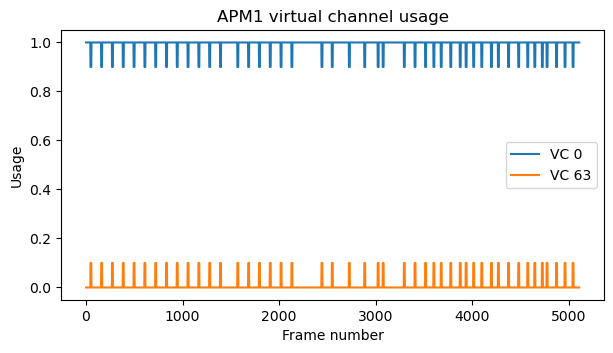

In [11]:
navg = 10
for v in set(vcid):
    plt.plot(np.convolve(vcid == v, np.ones(navg)/navg, mode='valid'), label=f'VC {v}')
plt.legend()
plt.title('APM1 virtual channel usage')
plt.xlabel('Frame number')
plt.ylabel('Usage');

In [12]:
[a.ocf for a in tm[:10]]

[Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=0, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=False, wait=False, retransmit=False, farm_b_counter=1, rsvd_spare2=0, report_value=245),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=0, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=False, wait=False, retransmit=False, farm_b_counter=1, rsvd_spare2=0, report_value=245),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=0, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=False, wait=False, retransmit=False, farm_b_counter=1, rsvd_spare2=0, report_value=246),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=0, rsvd_spare=0, no_rf_avail=False, no_bit_lock=F

In [13]:
print(tm[0].ocf)

Container: 
    control_word_type = False
    clcw_version_number = 0
    status_field = 0
    cop_in_effect = 1
    virtual_channel_identification = 0
    rsvd_spare = 0
    no_rf_avail = False
    no_bit_lock = False
    lock_out = False
    wait = False
    retransmit = False
    farm_b_counter = 1
    rsvd_spare2 = 0
    report_value = 245


In [14]:
{(a.ocf.control_word_type, a.ocf.clcw_version_number, a.ocf.status_field, a.ocf.cop_in_effect,
  a.ocf.virtual_channel_identification, a.ocf.rsvd_spare, a.ocf.no_rf_avail, a.ocf.no_bit_lock,
  a.ocf.lock_out, a.ocf.retransmit, a.ocf.farm_b_counter, a.ocf.rsvd_spare2) for a in tm if a.primary_header.virtual_channel_id == 0}

{(False, 0, 0, 1, 0, 0, False, False, False, False, 1, 0)}

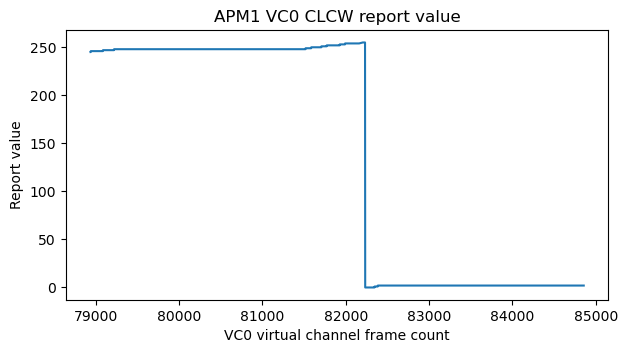

In [15]:
rv = [a.ocf.report_value for a in tm if a.primary_header.virtual_channel_id == 0]
plt.plot(vcfc[vcid == 0], rv)
plt.title('APM1 VC0 CLCW report value')
plt.xlabel('VC0 virtual channel frame count')
plt.ylabel('Report value');

In [16]:
rv[-1] + 256 - rv[0] + 1

14

## VC 0

VC 0 contains Space Packets using M_PDU. Strangely, most packets have the version field set to 1 instead of 0. APID 255 instead of 2047 is used for idle space packets. Most of the contents of these are filled with the ASCII `IDLE`. Non-idle frames have a 10-byte secondary header that contains a timestamp with 32-bit integer part and 16-bit fractional part and uses the J2000 epoch.

In [17]:
packets = list(ccsds.extract_space_packets(tm, 0xe0, 0))

/home/daniel/contracting/APM1/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 224 VC 0] Broken stream. Last frame count 79016, current frame count 79018
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/APM1/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 224 VC 0] Broken stream. Last frame count 79861, current frame count 79863
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/APM1/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 224 VC 0] Broken stream. Last frame count 80388, current frame count 80396
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count

In [18]:
headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets]
apids = collections.Counter([p.APID for p in headers])
apids

Counter({255: 3649,
         95: 3227,
         77: 1293,
         74: 646,
         72: 646,
         41: 642,
         128: 641,
         45: 641,
         69: 640,
         75: 379,
         112: 328,
         78: 325,
         80: 325,
         130: 325,
         228: 325,
         121: 324,
         197: 324,
         114: 324,
         67: 324,
         73: 323,
         119: 322,
         18: 322,
         229: 322,
         70: 322,
         48: 318,
         196: 315,
         38: 210,
         120: 162,
         118: 161,
         113: 158,
         125: 156,
         49: 109,
         40: 106,
         39: 101,
         116: 86,
         115: 85,
         117: 83,
         124: 83,
         123: 82,
         122: 79,
         98: 79,
         19: 79,
         84: 55,
         43: 54,
         81: 54,
         83: 54,
         131: 53,
         68: 53,
         82: 53,
         53: 33,
         221: 3})

In [19]:
headers[:10]

[Container(ccsds_version=1, packet_type=0, secondary_header_flag=True, APID=95, sequence_flags=3, packet_sequence_count_or_name=5257, data_length=341),
 Container(ccsds_version=1, packet_type=0, secondary_header_flag=True, APID=116, sequence_flags=3, packet_sequence_count_or_name=1169, data_length=141),
 Container(ccsds_version=1, packet_type=0, secondary_header_flag=True, APID=41, sequence_flags=3, packet_sequence_count_or_name=1115, data_length=148),
 Container(ccsds_version=1, packet_type=0, secondary_header_flag=False, APID=255, sequence_flags=3, packet_sequence_count_or_name=0, data_length=209),
 Container(ccsds_version=1, packet_type=0, secondary_header_flag=True, APID=77, sequence_flags=3, packet_sequence_count_or_name=4404, data_length=231),
 Container(ccsds_version=1, packet_type=0, secondary_header_flag=True, APID=69, sequence_flags=3, packet_sequence_count_or_name=8746, data_length=169),
 Container(ccsds_version=1, packet_type=0, secondary_header_flag=True, APID=78, sequence

In [20]:
collections.Counter([(p.ccsds_version, p.secondary_header_flag, p.APID) for p in headers])

Counter({(1, False, 255): 3649,
         (1, True, 95): 3227,
         (1, True, 77): 1293,
         (1, True, 74): 646,
         (1, True, 72): 646,
         (1, True, 41): 642,
         (0, True, 128): 641,
         (1, True, 45): 641,
         (1, True, 69): 640,
         (1, True, 75): 379,
         (1, True, 112): 328,
         (1, True, 78): 325,
         (1, True, 80): 325,
         (1, True, 130): 325,
         (1, True, 228): 325,
         (1, True, 121): 324,
         (1, True, 197): 324,
         (1, True, 114): 324,
         (1, True, 67): 324,
         (1, True, 73): 323,
         (1, True, 119): 322,
         (1, True, 18): 322,
         (1, True, 229): 322,
         (1, True, 70): 322,
         (1, True, 48): 318,
         (1, True, 196): 315,
         (1, True, 38): 210,
         (1, True, 120): 162,
         (1, True, 118): 161,
         (1, True, 113): 158,
         (1, True, 125): 156,
         (1, True, 49): 109,
         (1, True, 40): 106,
         (1, True, 39): 

In [21]:
by_apid = {apid: [p for p, h in zip(packets, headers) if h.APID == apid]
           for apid in apids}

In [22]:
[a[6:] for a in by_apid[255][:10]]

[b'\x08?\x00\x1e\x00\x00LEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEID',
 b'\x08?\x00\x1e\x00\x00LEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLE',
 b'\x08?\x00\x1e\x00\x00LEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLE',
 b'\x08?\x00\x1e\x00\x00LEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEIDLEI

In [23]:
by_apid[255][0][6:12].hex()

'083f001e0000'

In [24]:
sec_headers = np.array([np.frombuffer(p[6:16], 'uint8') for p in packets if ccsds.SpacePacketPrimaryHeader.parse(p).APID != 255])

In [25]:
sec_headers[:20, :2]

array([[  8,  47],
       [  8, 238],
       [  8, 238],
       [ 12,  63],
       [  8, 238],
       [  8, 238],
       [  8, 238],
       [  8,  47],
       [  8, 238],
       [  8, 238],
       [  8, 238],
       [  8,  47],
       [  8, 238],
       [  8,  47],
       [  4,  79],
       [  8, 238],
       [  8, 238],
       [  4,  79],
       [ 12,  79],
       [  8,  47]], dtype=uint8)

In [26]:
collections.Counter([(a[0], a[1]) for a in sec_headers[:, :2]])

Counter({(8, 238): 10631,
         (8, 47): 3230,
         (12, 63): 971,
         (12, 79): 648,
         (4, 79): 641,
         (8, 63): 33})

In [27]:
np.all(sec_headers[:, 2:4] == sec_headers[0, 2:4])

True

In [28]:
sec_headers[0, 2:4]

array([ 0, 30], dtype=uint8)

In [29]:
bin(30), hex(30)

('0b11110', '0x1e')

In [30]:
timestamps = sec_headers[:, 4:8].view('uint32').byteswap().ravel()
timestamps = timestamps + sec_headers[:, 8:].view('uint16').byteswap().ravel() / 2**16
timestamps = np.datetime64('2000-01-01T12:00:00') + np.timedelta64(1, 'ns') * (1e9 * timestamps)

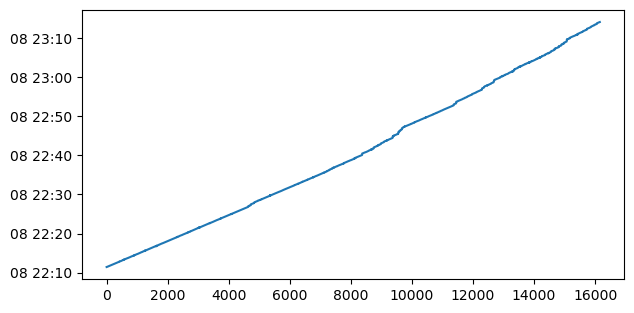

In [31]:
plt.plot(timestamps)

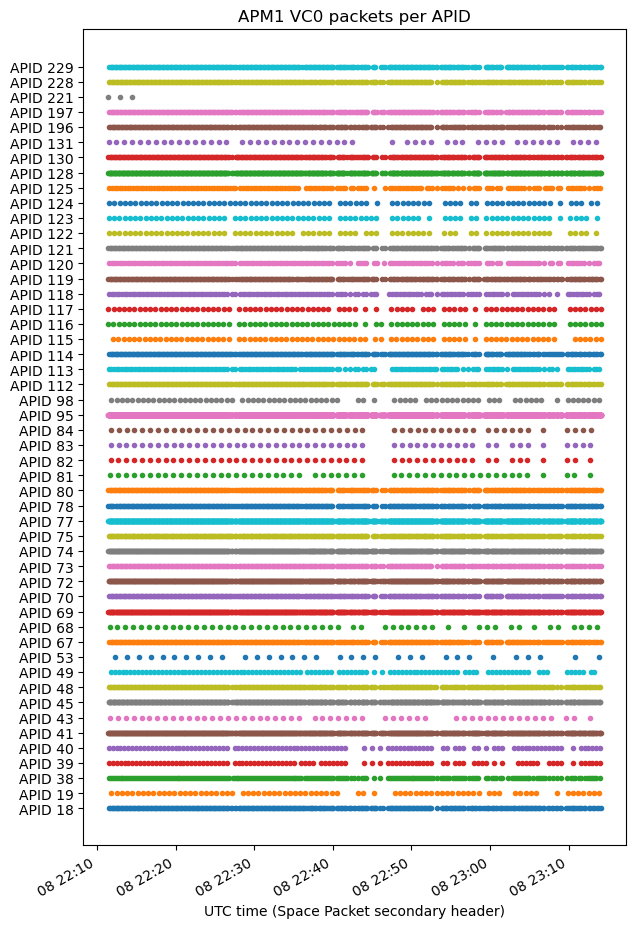

In [32]:
headers_noidle = [p for p in headers if p.APID != 255]

plt.figure(figsize=(7, 12))
for j, apid in enumerate(sorted([a for a in apids if a != 255])):
    tstamps = np.array([t for t, h in zip(timestamps, headers_noidle) if h.APID == apid])
    plt.plot(tstamps, [j] * tstamps.size, '.')
yticks = [f'APID {a}' for a in sorted(apids) if a != 255]
plt.yticks(np.arange(len(yticks)), yticks)
plt.gcf().autofmt_xdate()
plt.title('APM1 VC0 packets per APID')
plt.xlabel('UTC time (Space Packet secondary header)');

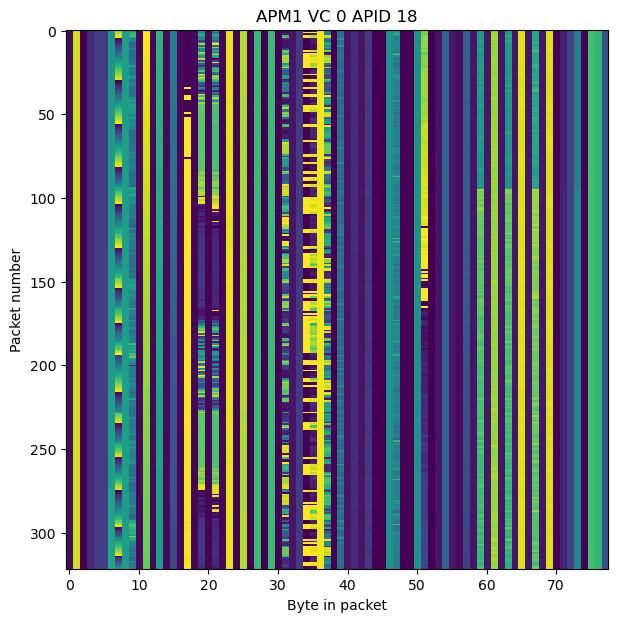

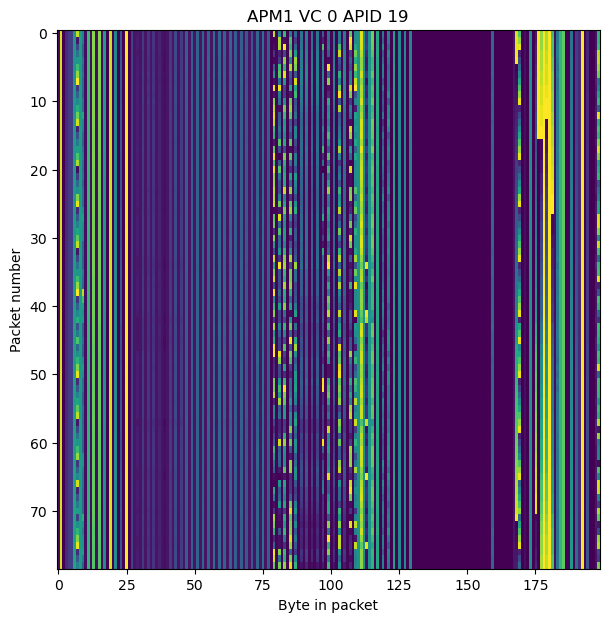

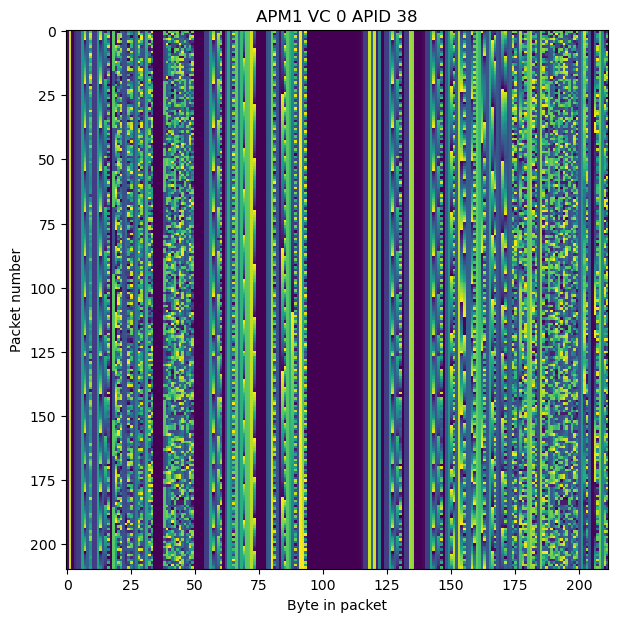

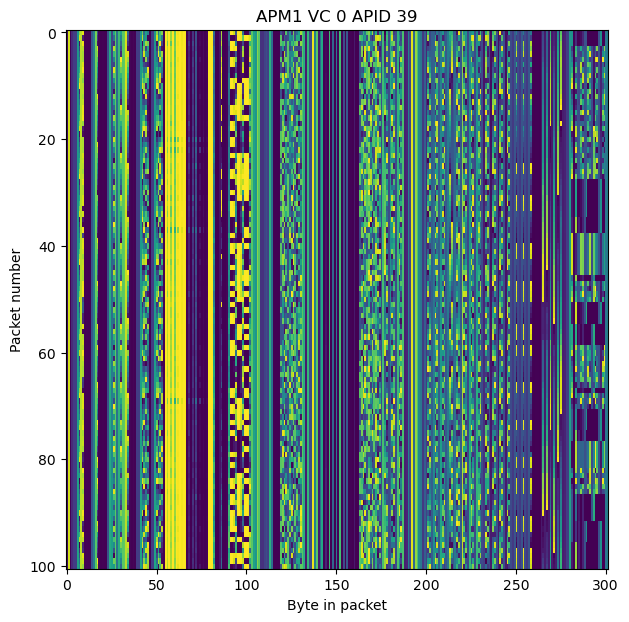

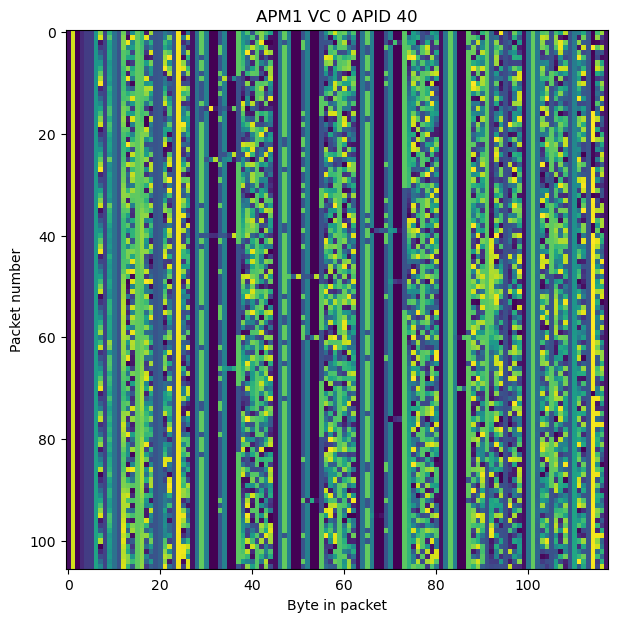

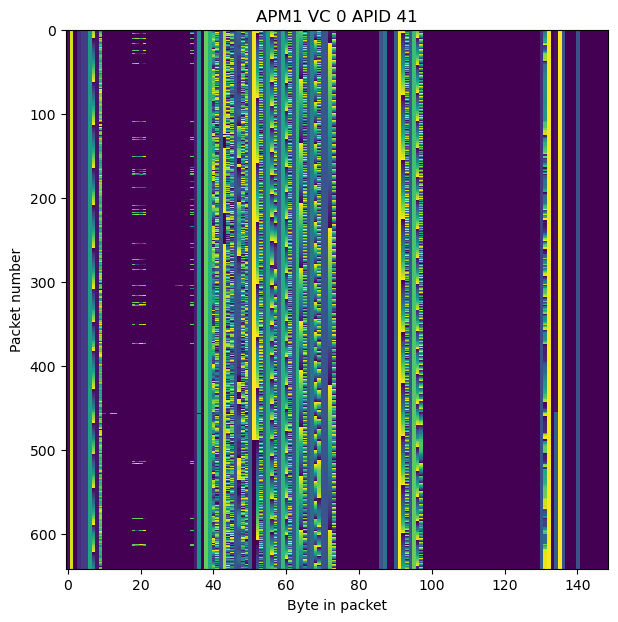

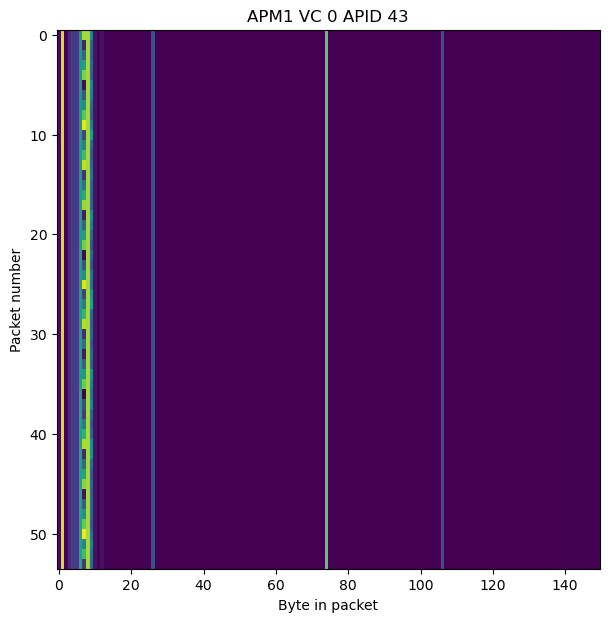

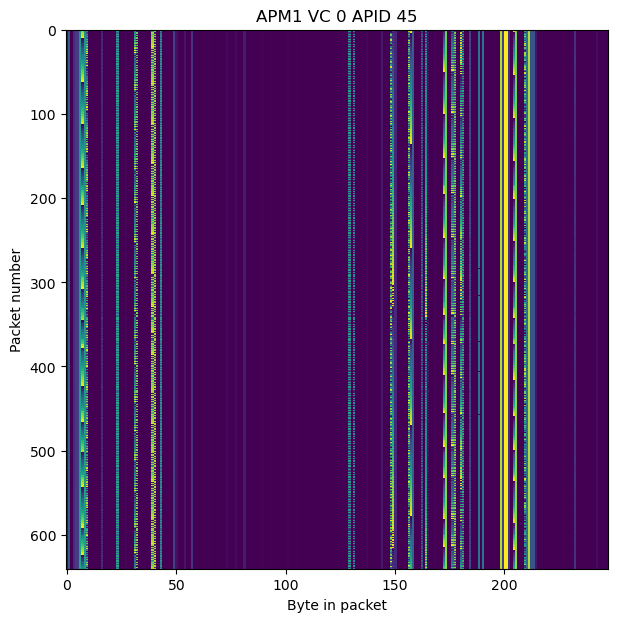

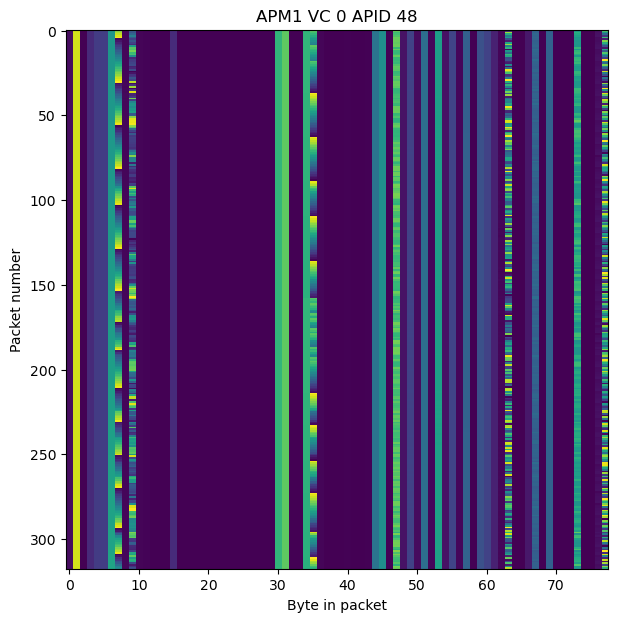

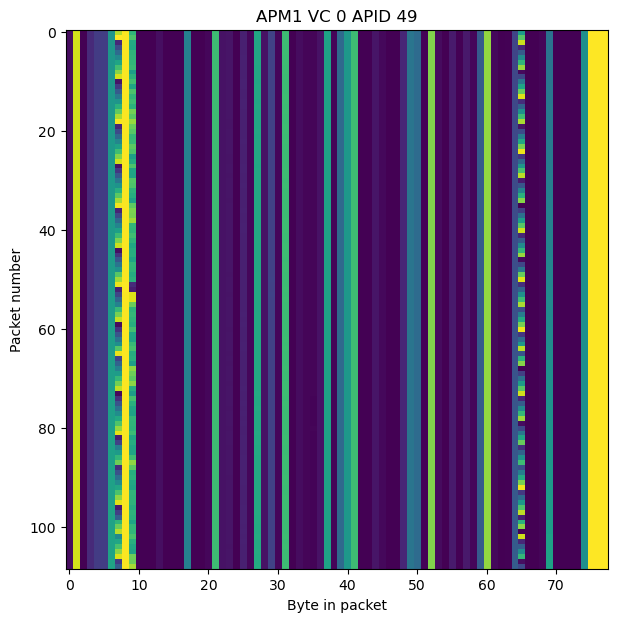

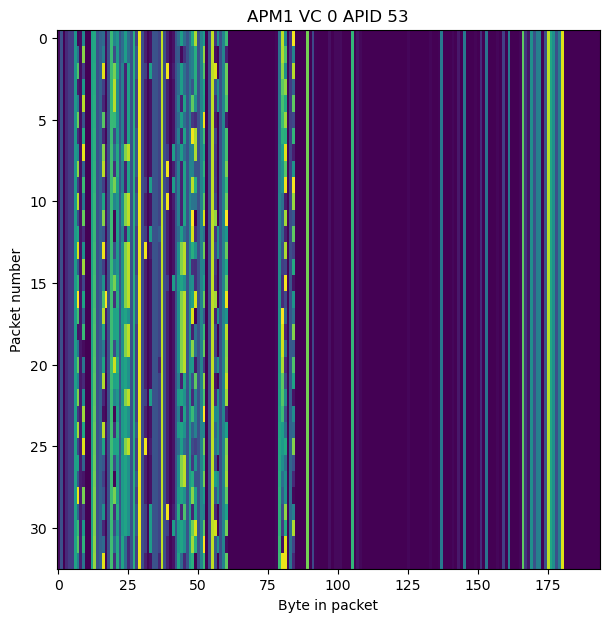

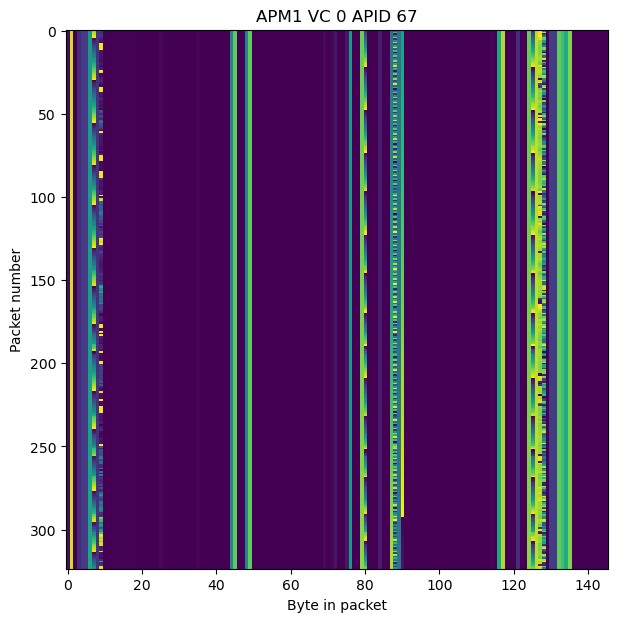

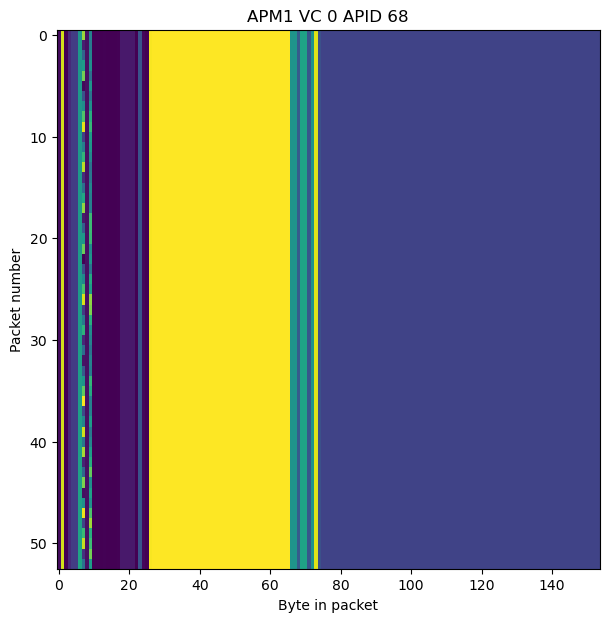

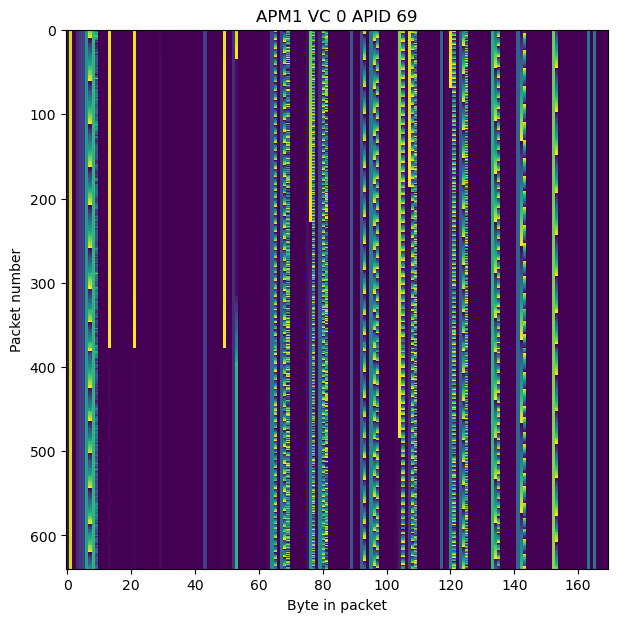

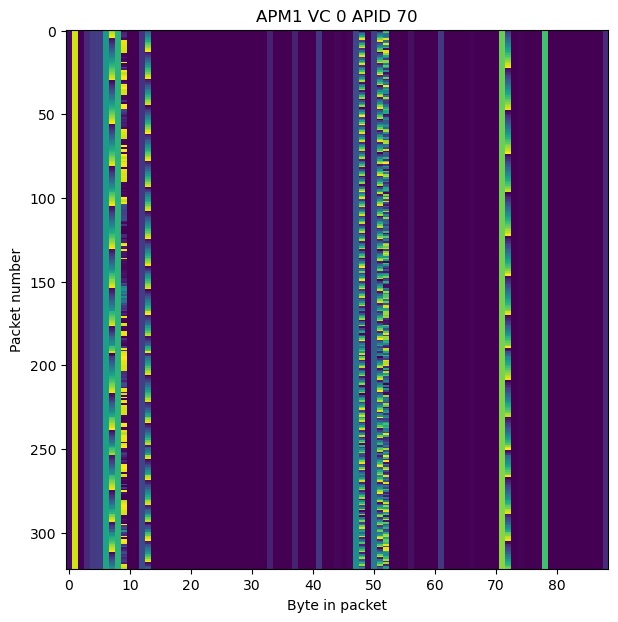

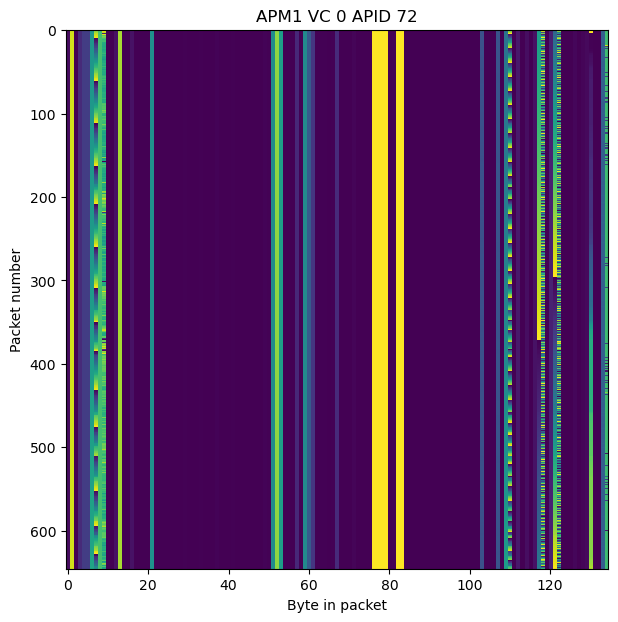

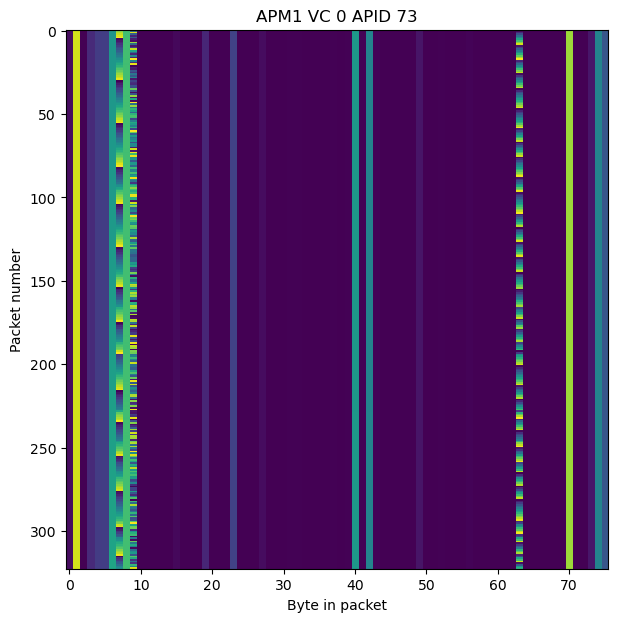

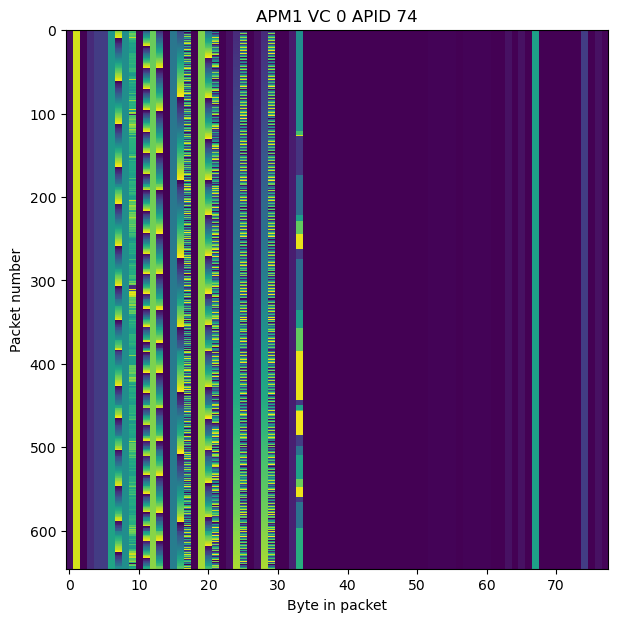

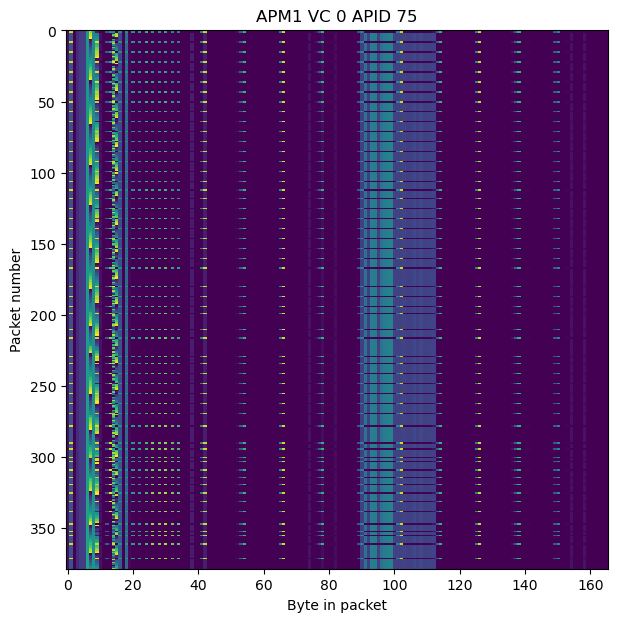

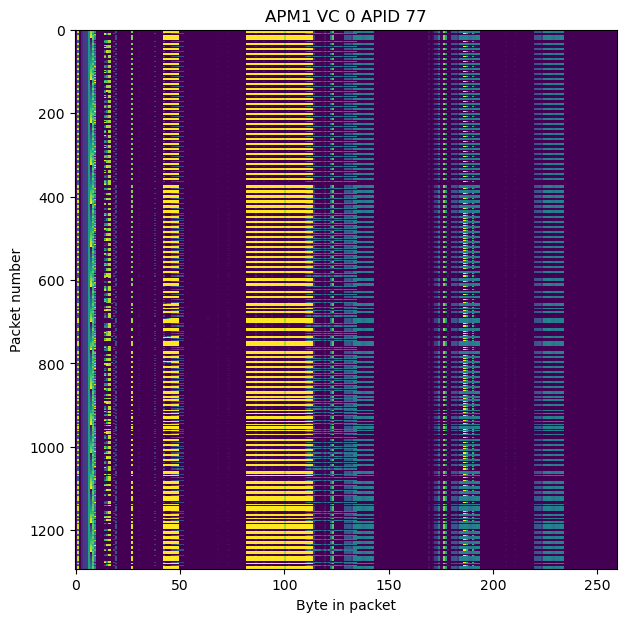

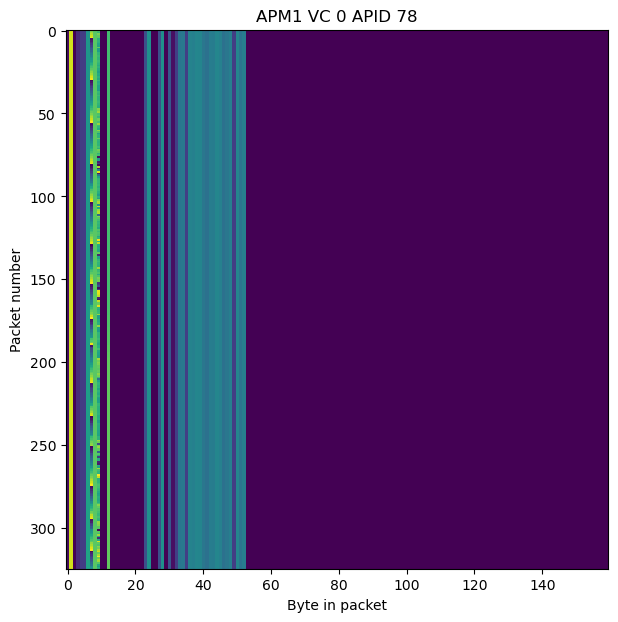

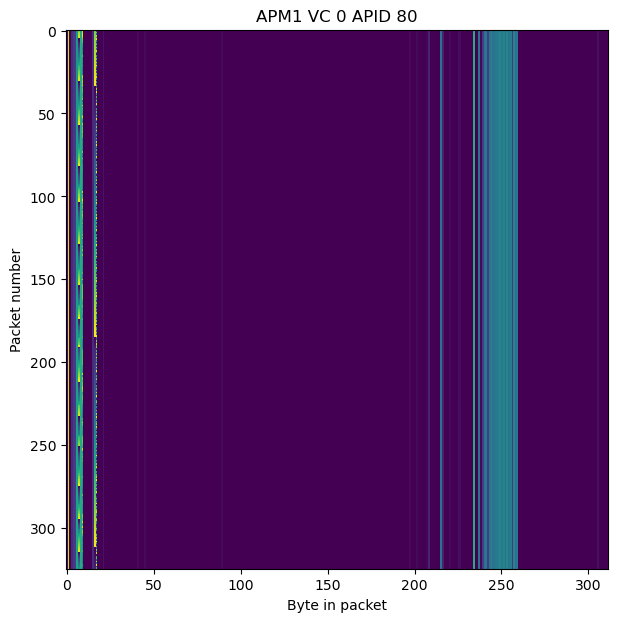

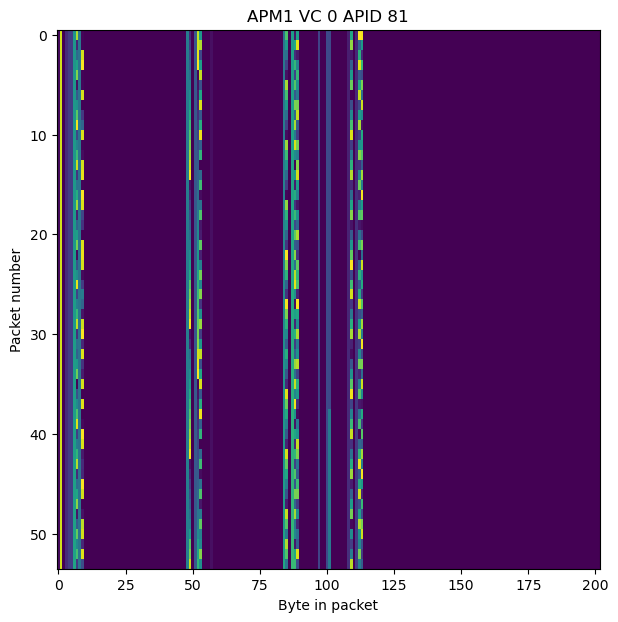

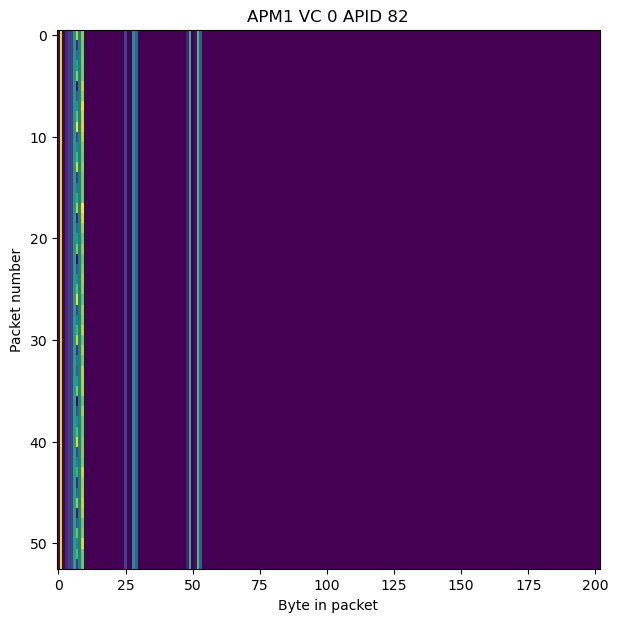

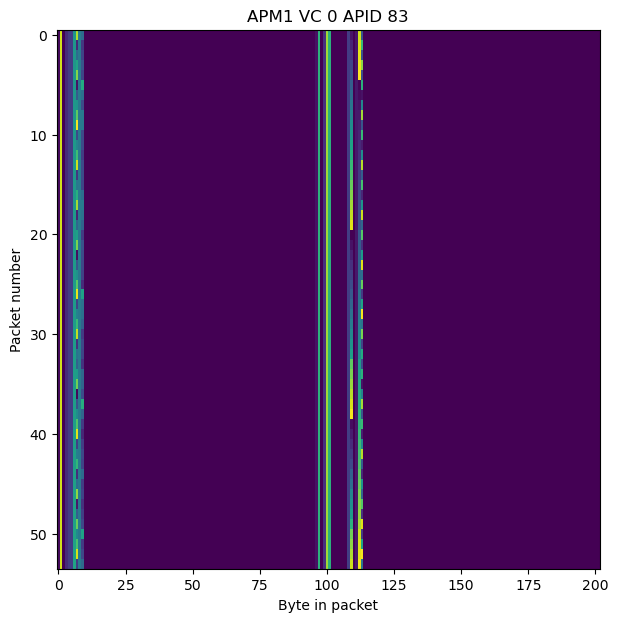

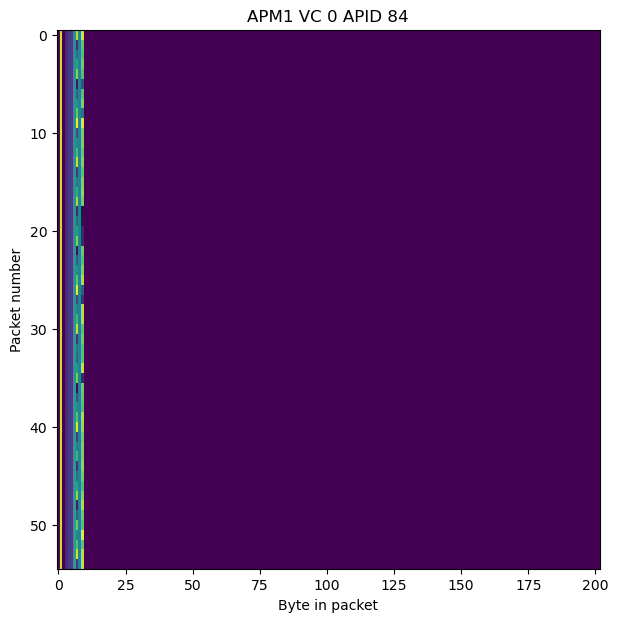

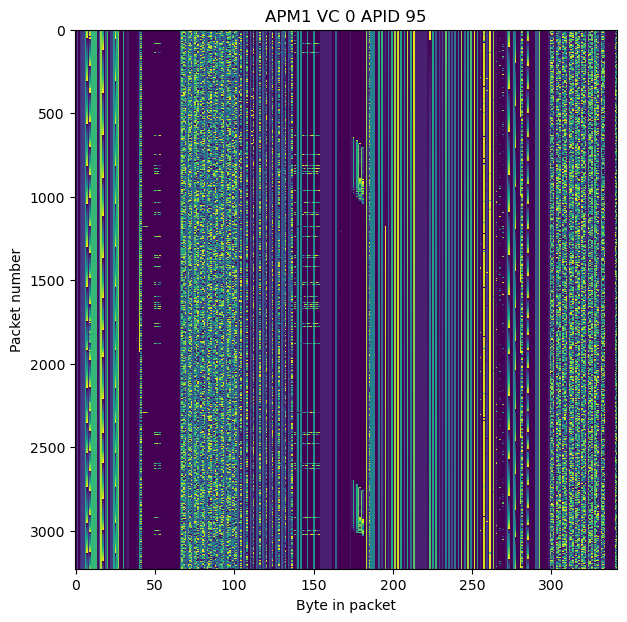

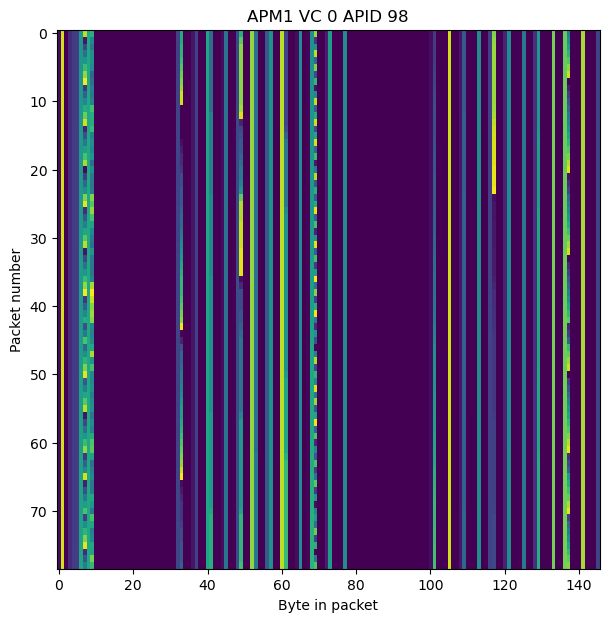

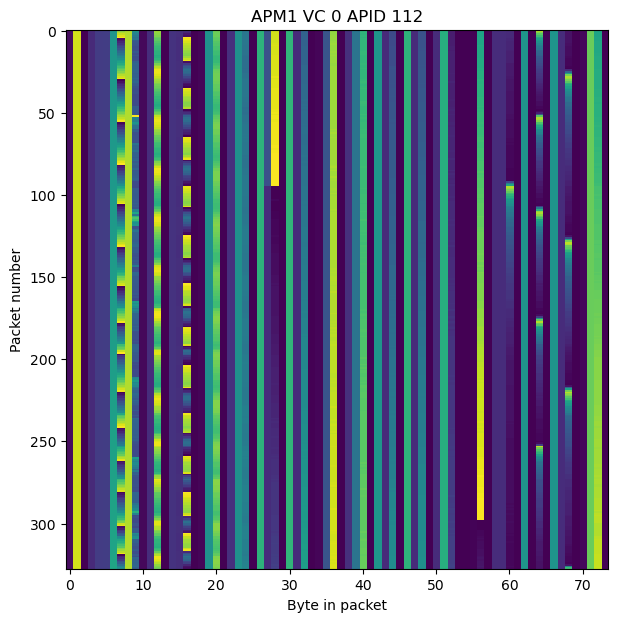

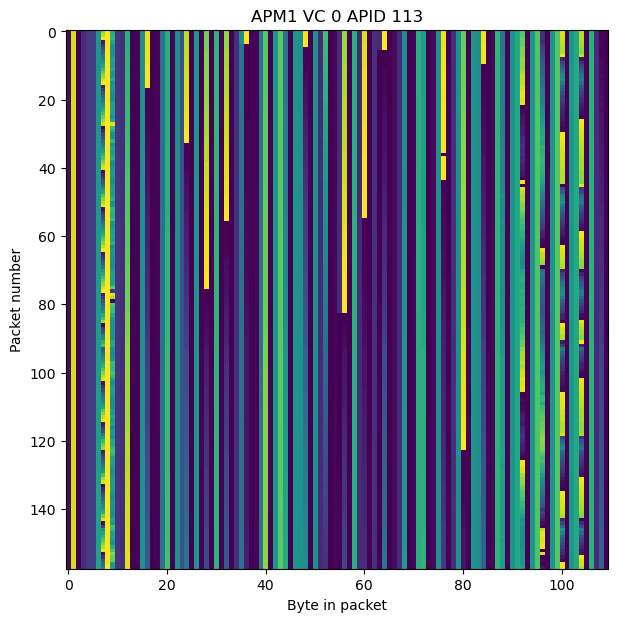

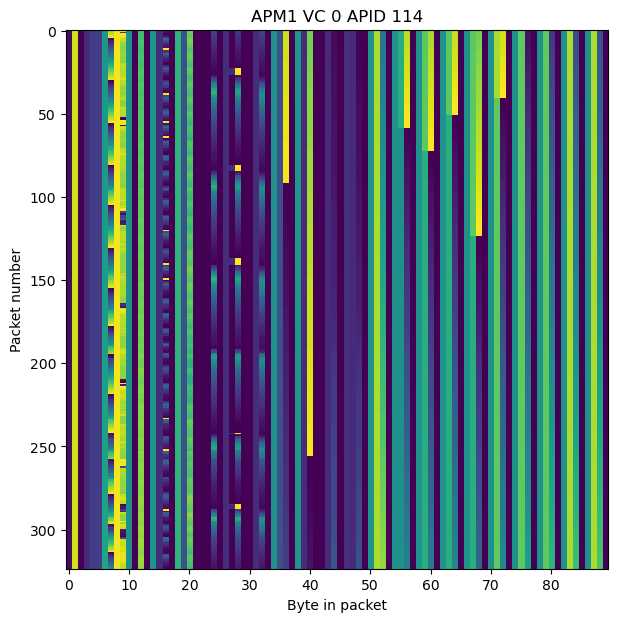

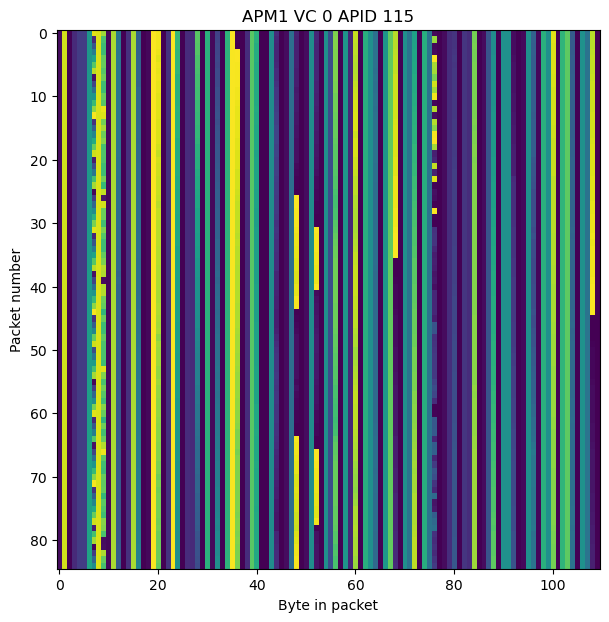

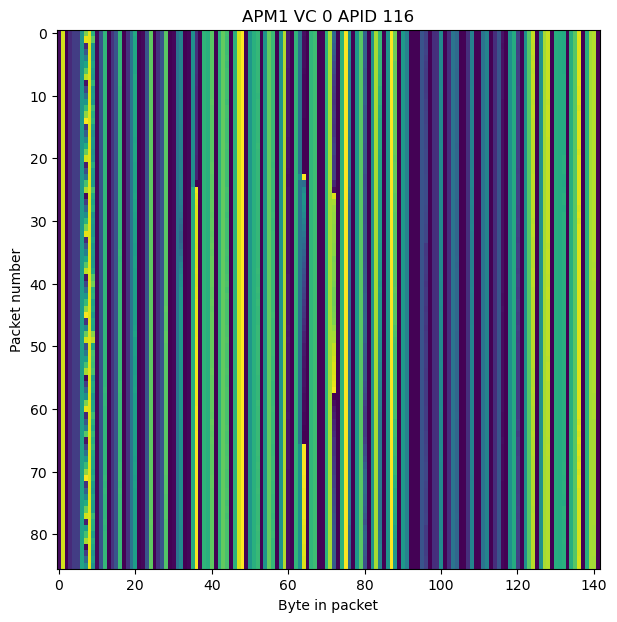

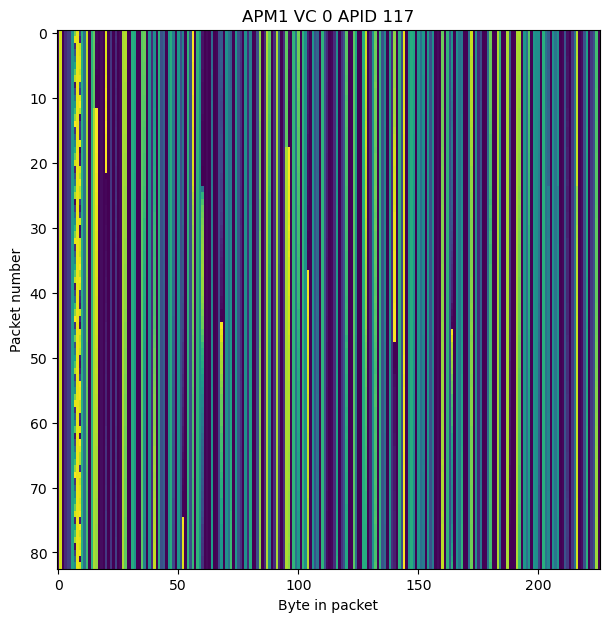

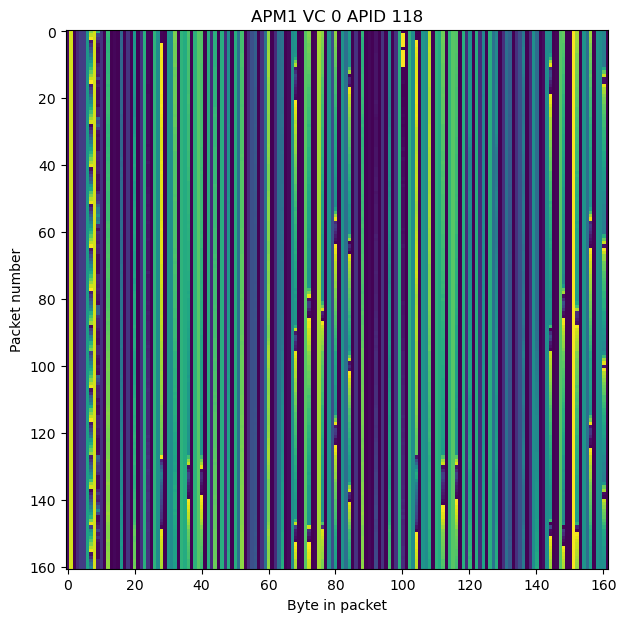

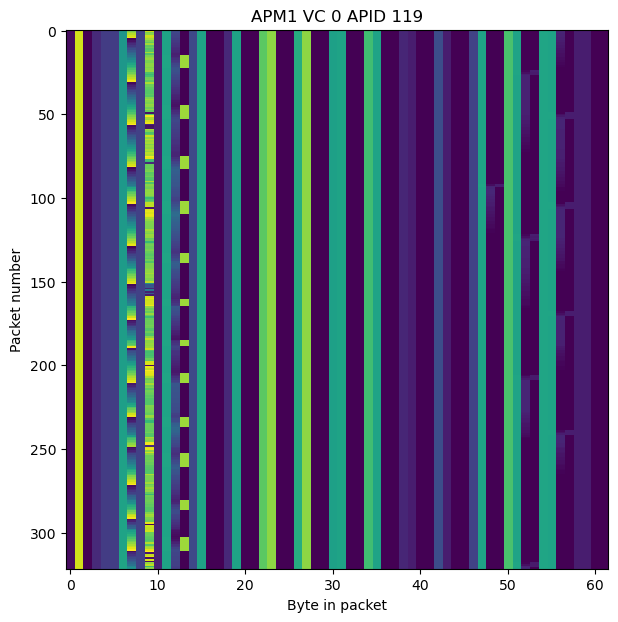

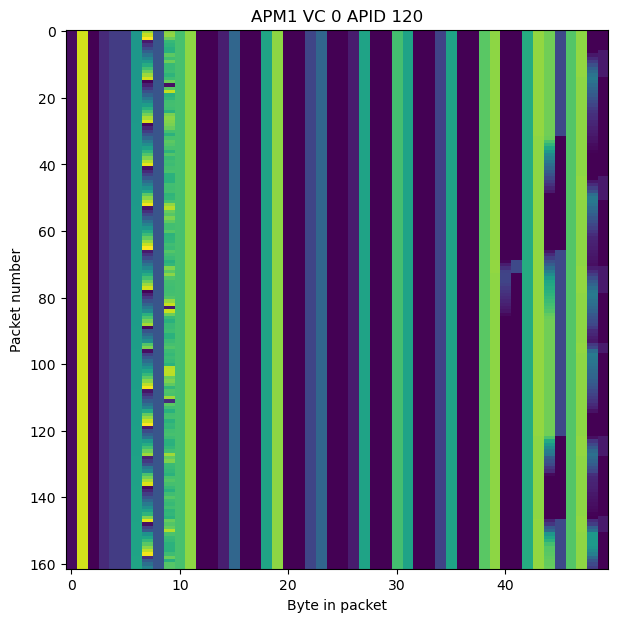

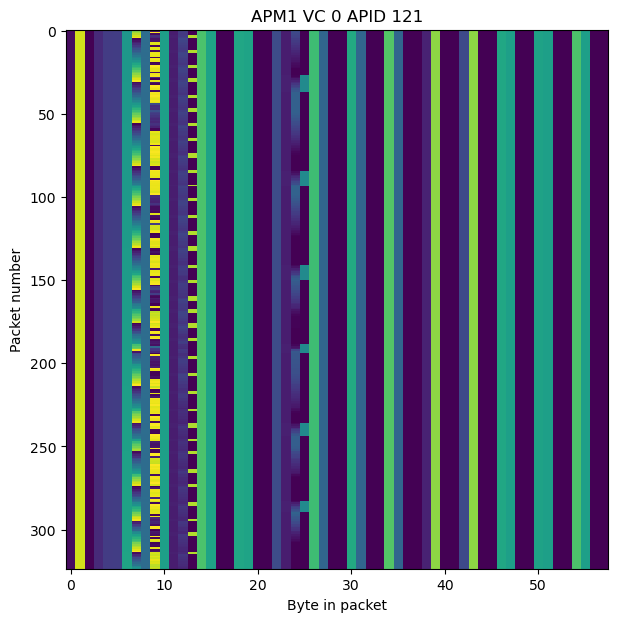

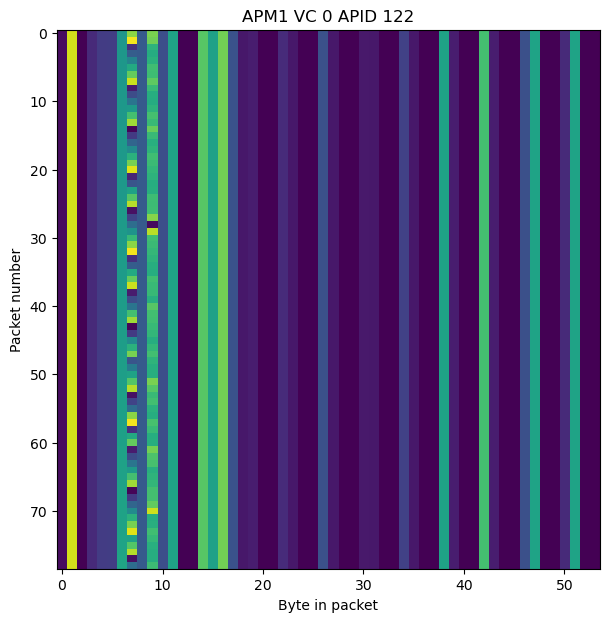

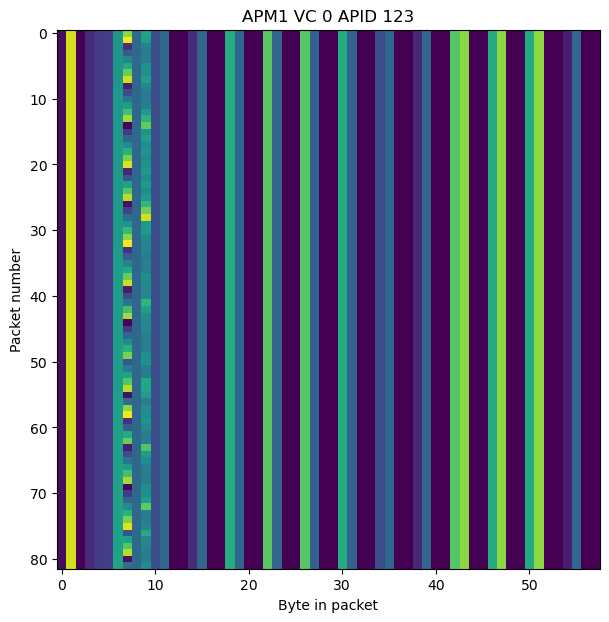

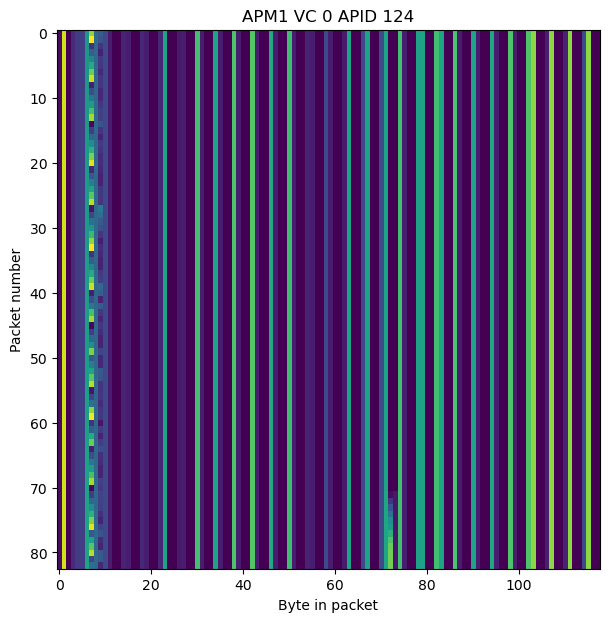

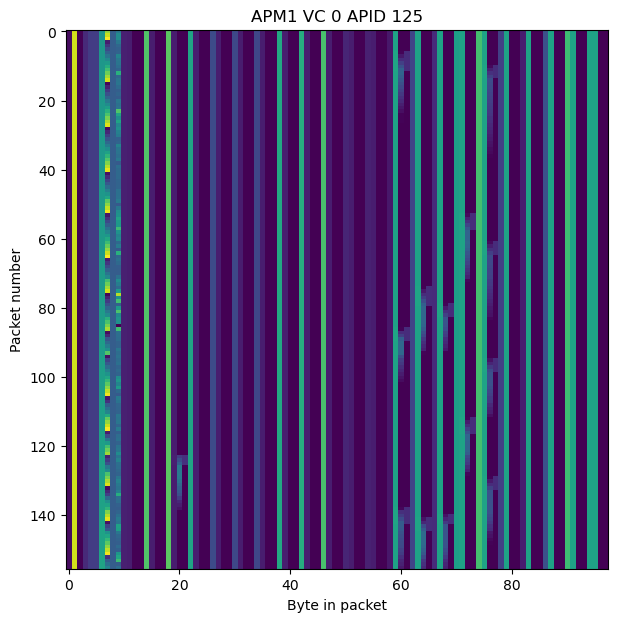

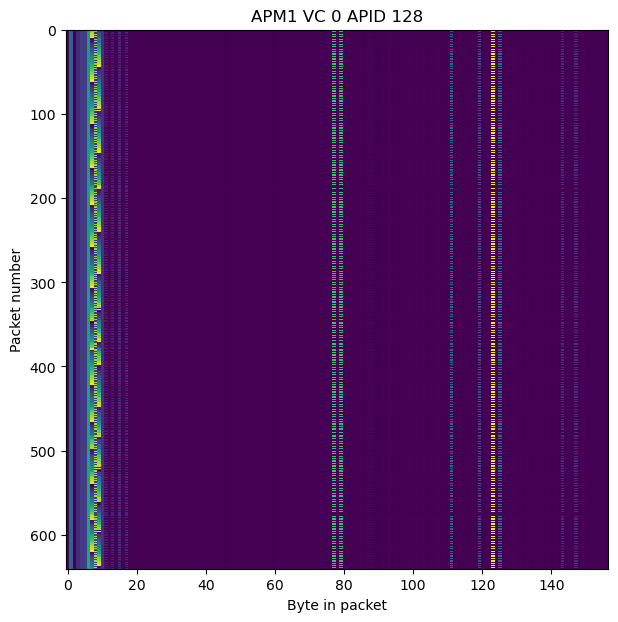

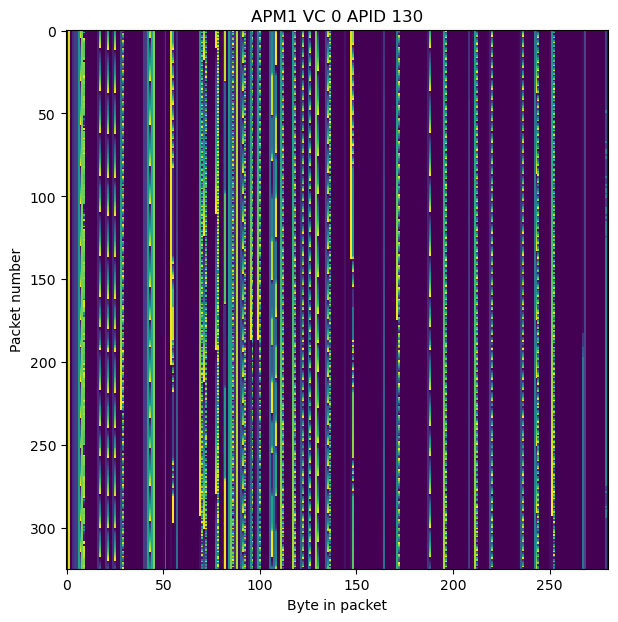

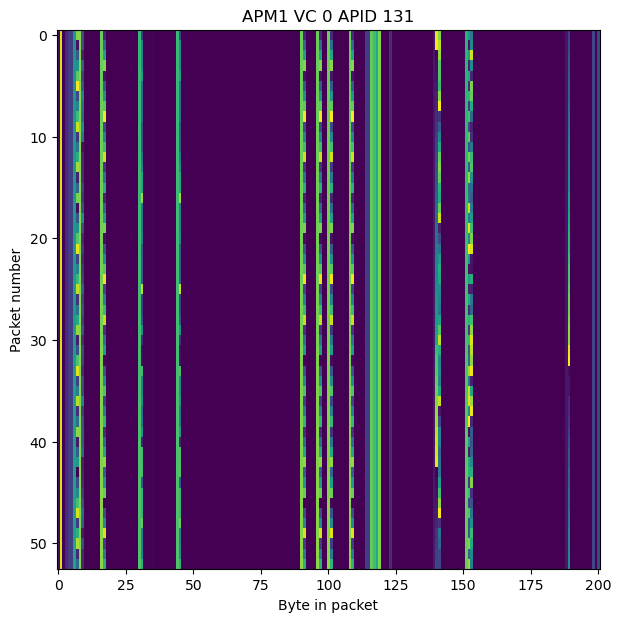

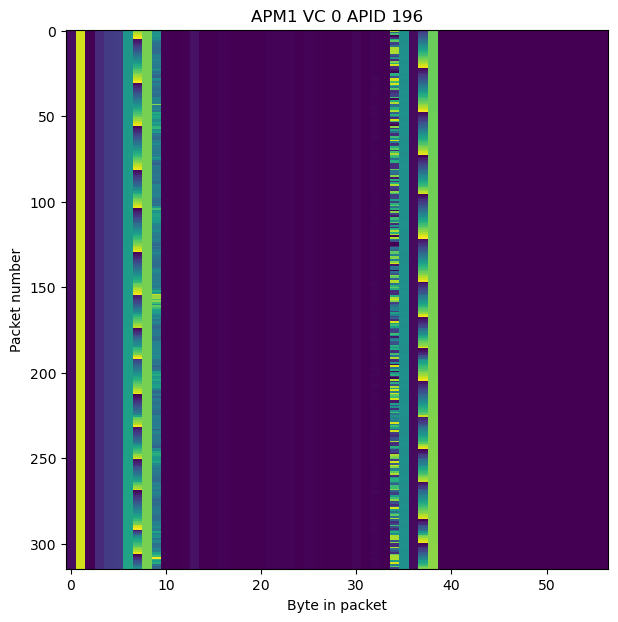

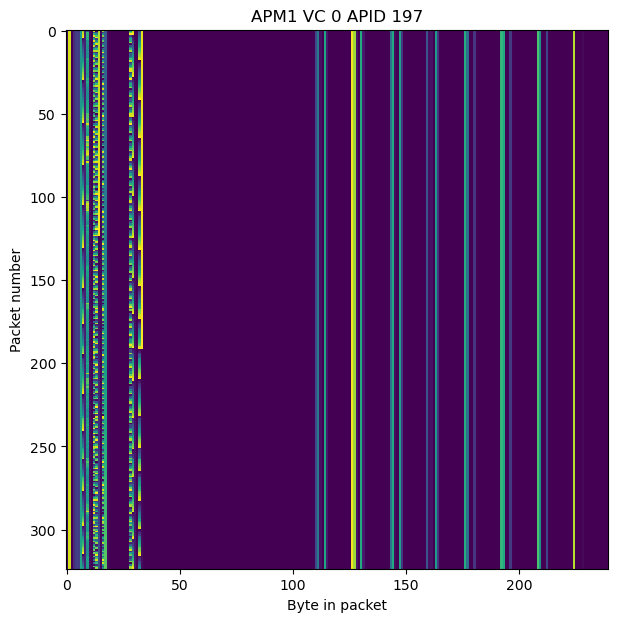

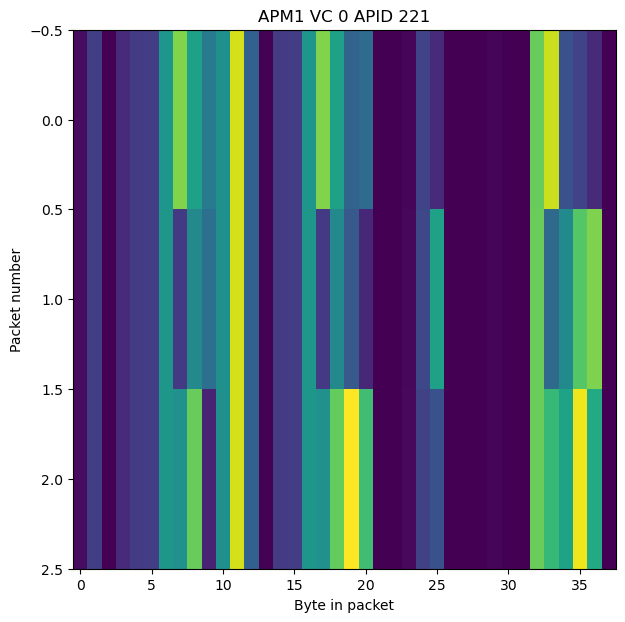

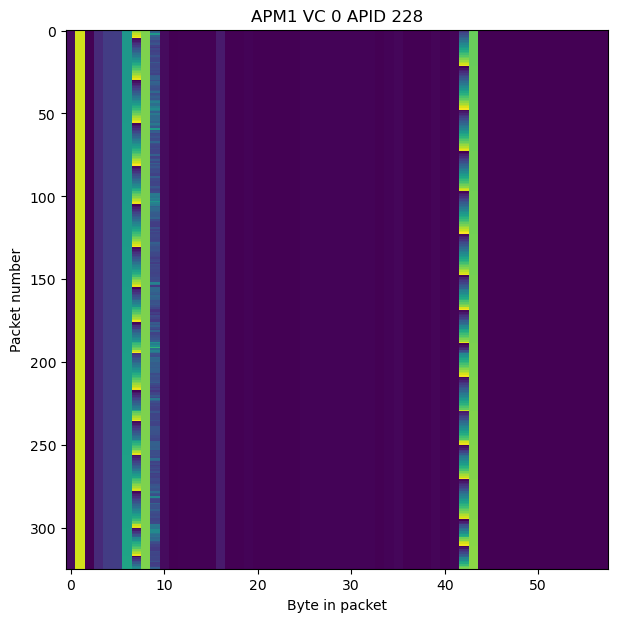

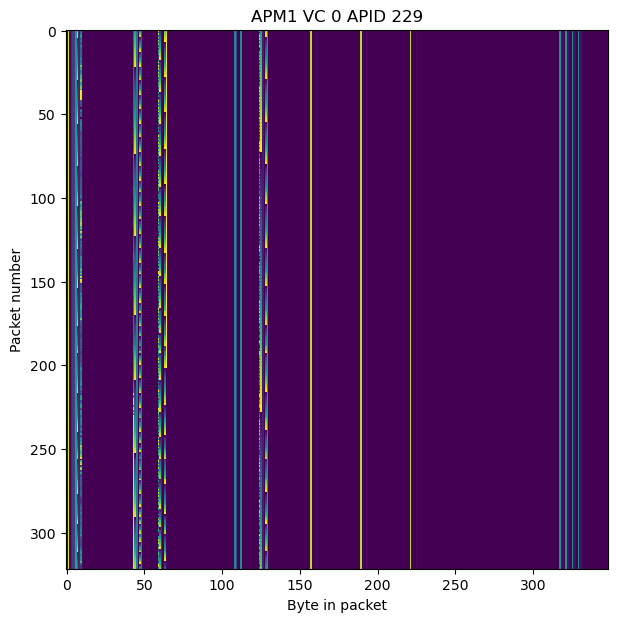

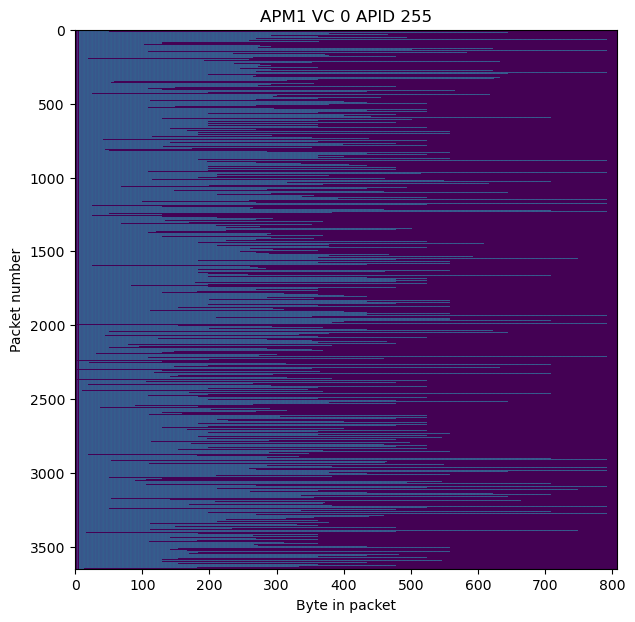

In [33]:
apid_array = {}
for apid in sorted(apids):
    if apid == 2047:
        continue
    ps = [np.frombuffer(p[6:], 'uint8') for p in by_apid[apid]]
    ml = max([len(p) for p in ps])
    plt.figure(figsize=(7, 7))
    apid_array[apid] = np.array([np.concatenate((p, np.zeros(ml - len(p), 'uint8'))) for p in ps])
    plt.imshow(apid_array[apid], aspect='auto', interpolation='none', vmin=0, vmax=255)
    plt.title(f'APM1 VC 0 APID {apid}')
    plt.xlabel('Byte in packet')
    plt.ylabel('Packet number')

## VC 63

VC 63 frames idle frames are filled with `0x8d` bytes. The don't contain an M_PDU header.

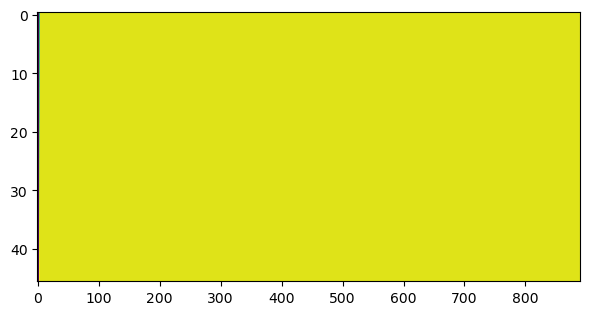

In [34]:
plt.imshow(frames[vcid == 63], aspect='auto', interpolation='none');

In [35]:
np.all(frames[vcid == 63][:, 6:] == 0x8d)

True